# Choosing a location for a well

The 'Oil 3000' production company has to decide where to drill a new well.

We are given oil samples from three regions: each has 10,000 oil fields, where we have measured the quality of the oil and the volume of its reserves. We will build a machine learning model that will help us determine the region where production will bring the most profit. Let's analyze the possible profits and risks using *Bootstrap.*

Steps for selecting a location:

- In the selected region look for fields, for each determine the values of the features;
- Build a model and estimate the volume of reserves;
- Select fields with the highest value estimates. The number of fields depends on the company's budget and the cost of developing one well;
- Profit is equal to the total profit of the selected fields.

## 1. Preprocessing

Import pandas, numpy, sklearn libraries for further work and write the constants:

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

BUDGET = 10_000_000_000
ALL_OIL_WELLS = 500
BEST_OIL_WELLS = 200
INCOME_UNIT_PRODUCT = 450_000
ALPHA = 0.025
BOOTSTRAP_SAMPLES = 1_000

Let's put the exploration data of the three regions into dataframes:

In [2]:
try:
    data_geo_0 = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\geo_data_0.csv')
    data_geo_1 = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\geo_data_1.csv')
    data_geo_2 = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\geo_data_2.csv')
except:
    data_geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_geo_1 = pd.read_csv('/datasets/geo_data_1.csv')        
    data_geo_2 = pd.read_csv('/datasets/geo_data_2.csv')    

Let's unload the information and the first 5 dataframe lines with data for region 0, also check the data for duplicates and missing values:

In [3]:
print('Duplicates:', data_geo_0.duplicated().sum(), '\n')
print('Missing values:', data_geo_0.isna().sum(), '\n')
data_geo_0.info()
data_geo_0.head()

Duplicates: 0 

Missing values: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


There are no duplicates and missing values in region 0, data types match the description.

Let's unload the information and the last 5 dataframe lines with data on region 1, also check the data for duplicates and missing values

In [4]:
print('Duplicates:', data_geo_1.duplicated().sum(), '\n')
print('Missing values:', data_geo_1.isna().sum(), '\n')
data_geo_1.info()
data_geo_1.tail()

Duplicates: 0 

Missing values: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364
99999,relB0,-3.426139,-7.794274,-0.003299,3.179103


Дубликаты и пропущенные значения регионе 1 отсутствуют, типы данных соответсвуют описанию.

Выгрузим информацию и случайные 5 строк датафрейма с данными по региону 2, также проверим данные на предмет дубликатов и пропущенных значений:

In [5]:
print('Duplicates:', data_geo_2.duplicated().sum(), '\n')
print('Missing values:', data_geo_1.isna().sum(), '\n')
data_geo_2.info()
data_geo_2.sample(5)

Duplicates: 0 

Missing values: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
42825,3BYAV,2.477216,0.839715,6.786225,84.760268
2033,VLV1P,2.289284,0.394494,-1.209891,55.751632
10802,6DxTZ,0.123080,0.823457,-1.720953,12.035335
69225,6CSD7,-0.057147,2.407264,6.683261,149.333180
36202,A72xY,0.915950,2.429553,-2.619895,68.967390


There are no duplicates and missing values in region 2, the data types match the description.

Let's construct an overall histogram for all numeric columns of the dataframe for region 0, and study the information obtained by `describe()`:

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


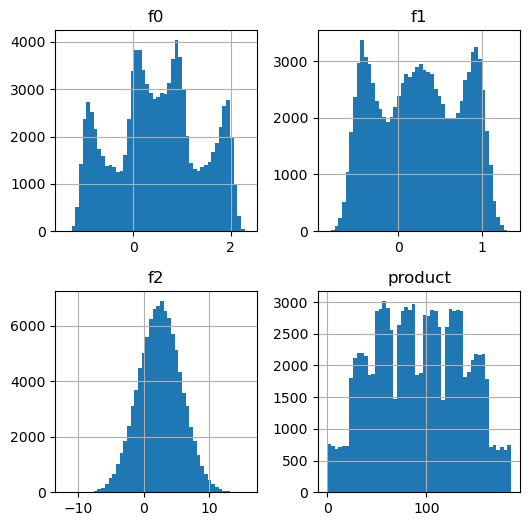

In [6]:
data_geo_0.hist(figsize=(6, 6),bins=50);
data_geo_0.describe()

The distribution of features `f0`, `f1` and `product` does not look normal, the features `f2` has a normal distribution. The most interesting feature is `product` (volume of reserves in a well (thousand barrels)), its maximum value in region 0 - 185 thousand barrels, average 92.5 thousand barrels

Let's construct an overall histogram for all numeric columns of the dataframe for region 1, and examine the information obtained by `describe()`:

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


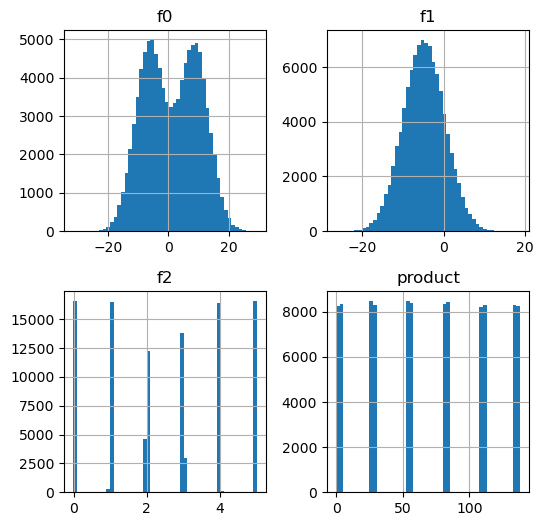

In [7]:
data_geo_1.hist(figsize=(6, 6),bins=50);
data_geo_1.describe()

The distribution of features `f0`, `f2` and `product` does not look normal, the features `f1` has a normal distribution. The maximum value of the sign `product` in region 1 is 137 thousand barrels, the average is 68.8 thousand barrels, these are significantly lower values compared with region 0.

Let's construct an overall histogram for all the numeric columns of the dataframe for region 2, and examine the information obtained by `describe()`:

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


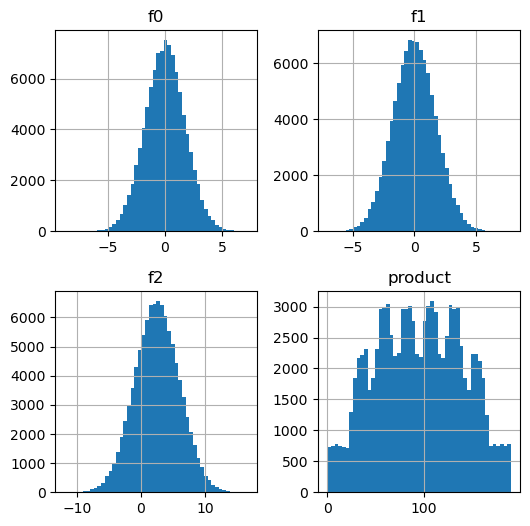

In [8]:
data_geo_2.hist(figsize=(6, 6),bins=50);
data_geo_2.describe()

The data of region 2 looks noticeably better than the previous ones, in this region only the distribution of the sign `product` does not look normal, the other signs `f0`, `f1` and `f2` have normal distribution. The maximum value of a sign `product` in region 2 is 190 thousand barrels, average 95 thousand barrels, these data tell us about more considerable volumes of stocks in a well in comparison to other regions

**Conclusion:**
- We imported `pandas`, `sklearn`, `numpy` libraries, unloaded data using `describe()`, `info()` methods and analyzed them
- checked the data for duplicates and missing values, found that there were no duplicates and missing values in the data
- We plotted histograms for all numeric features of the three regions and found that the distribution of some features differ from the normal, the scale of distribution of features `f0`, `f1` and `f2` do not differ significantly, so we will not apply scaling in the future
- we analyzed the data and made a conclusion that maximum value of indicator in region 2 is 190 thousand barrels, average value is 95 thousand barrels, this data tells us about more significant reserves in the well in comparison to other regions (region 0: mean=92.5, max=185; region 1: mean=68.8, max=138)
- we do not know what signs `f0`, `f1` and `f2` mean, so it is difficult to assess the adequacy of distributions and emissions, we leave the data unchanged

## 2. Model training and validation

Split the data into **features** (`f0`, `f1` and `f2`) and the target feature **target** (`product`)

In [9]:
features = ['f0', 'f1', 'f2']
target = ['product']
features_0 = data_geo_0[features]
features_1 = data_geo_1[features]
features_2 = data_geo_2[features]
target_0 = data_geo_0[target]
target_1 = data_geo_1[target]
target_2 = data_geo_2[target]

Split the data into training and validation samples in the ratio of 75:25 and check the resulting sample size:

In [10]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0,
                                                                                      target_0,
                                                                                      test_size=0.25, random_state=12345)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1,
                                                                                      target_1,
                                                                                      test_size=0.25, random_state=12345)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2,
                                                                                      target_2,
                                                                                      test_size=0.25, random_state=12345)
print(f'Region 0 training sample size: {len((features_train_0) + (target_train_0))/ len(data_geo_0):.0%}', end=' | ')
print(f'Region 0 validation sample size: {len((features_valid_0) + (target_valid_0)) / len(data_geo_0):.0%}')
print(f'Region 1 training sample size:: {len((features_train_1) + (target_train_1))/ len(data_geo_1):.0%}', end=' | ')
print(f'Region 1 validation sample size: {len((features_valid_1) + (target_valid_1)) / len(data_geo_1):.0%}')
print(f'Region 2 training sample size:: {len((features_train_2) + (target_train_2))/ len(data_geo_2):.0%}', end=' | ')
print(f'Region 2 validation sample size: {len((features_valid_2) + (target_valid_2)) / len(data_geo_2):.0%}')

Region 0 training sample size: 75% | Region 0 validation sample size: 25%
Region 1 training sample size:: 75% | Region 1 validation sample size: 25%
Region 2 training sample size:: 75% | Region 2 validation sample size: 25%


Train the model (LinearRegression), make predictions on the validation sample, save the predictions and correct answers on the validation sample, display the average stock of predicted raw materials and the RMSE of the model

In [11]:
def print_predict_mean_rmse(region, predict_mean, rmse):
    print(region, end=' | ')
    print('average stock of predicted raw materials: ', predict_mean, end=' | ')
    print('RMSE: ', rmse)

In [12]:
def predict_mean_rmse(region, features_train, target_train, features_valid, target_valid, show_res=True, return_res=False):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    predict_mean = predict_valid.mean()
    rmse = mean_squared_error(target_valid, predict_valid)**0.5
    if show_res:
        print_predict_mean_rmse(region, predict_mean, rmse)
    if return_res:
        return rmse

In [13]:
predict_mean_rmse('Region 0', features_train_0, target_train_0, features_valid_0, target_valid_0)
predict_mean_rmse('Region 1', features_train_1, target_train_1, features_valid_1, target_valid_1)
predict_mean_rmse('Region 2', features_train_2, target_train_2, features_valid_2, target_valid_2)

Region 0 | average stock of predicted raw materials:  92.59256778438035 | RMSE:  37.5794217150813
Region 1 | average stock of predicted raw materials:  68.72854689544602 | RMSE:  0.893099286775617
Region 2 | average stock of predicted raw materials:  94.96504596800489 | RMSE:  40.02970873393434


From the data obtained, it follows that the highest average stock of predicted raw materials showed regions 0 (92.59) and 2 (94.96), the figure in region 1 is much lower (68.72), while the lowest value of the root mean square error (RMSE) showed region 1 (0.89). This demonstrates the accuracy of the predictions and the quality of the model, which cannot be said about regions 0 and 2, where the RMSE is rather high (37.57 and 40.02, respectively).

**Conclusion:**
- we trained and tested the model for each region
- we analyzed the results and found out that regions 0 (92.59) and 2 (94.96) showed the highest average stock of predicted raw materials, the figure in region 1 was significantly lower (68.72)
- we also found out that the lowest RMSE value was in region 1 (0.89), which shows the accuracy of the predictions and the quality of the built model, which cannot be said about regions 0 and 2, where the RMSE is rather high (37.57 and 40.02 respectively)

## 3 Preparation for Profit Calculation

Let's keep all the key values for calculations in separate variables (move them to the beginning of the project) and calculate the sufficient amount of feedstock for break-even development of a new well. Let's compare the resulting volume of feedstock with the average stock in each region.

Key figures:
- `budget` - budget for well development in the region


- `all_oil_wells` - number of points, which are explored during the exploration of the region


- `best_oil_wells` - number of best development points selected by machine learning from those explored during regional exploration 


- `income_unit_product` - income from each unit of product (volume is specified in thousands of barrels)


- `alpha` - probability of loss

In [14]:
volume = BUDGET / BEST_OIL_WELLS / INCOME_UNIT_PRODUCT
print('Minimum volume of feedstock for break-even development of a new well: ', volume, 'barrels')

Minimum volume of feedstock for break-even development of a new well:  111.11111111111111 barrels


**Conclusion:**
- The minimum feedstock volume for break-even development of a new well is 111 barrels. The figure was calculated on the basis of the 200 best points for development in the region
- Calculations yielded a result that exceeded the average for all three regions

## 4 Calculation of profits and risks

Let's write a function to calculate profits for selected wells and model predictions. Let's choose the wells with maximum predictions. Let's sum up the target value of the volume of raw material corresponding to these predictions. Let's calculate the profit for the obtained volume of raw material

In [15]:
def predict_valid(features_train, target_train, features_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    return predict_valid
predict_valid_0 = predict_valid(features_train_0, target_train_0, features_valid_0)
predict_valid_1 = predict_valid(features_train_1, target_train_1, features_valid_1)
predict_valid_2 = predict_valid(features_train_2, target_train_2, features_valid_2)

In [16]:
target_0 = pd.Series(target_valid_0['product']).reset_index(drop=True)
predict_0 = pd.Series(*predict_valid_0.reshape(1,-1))
target_1 = pd.Series(target_valid_1['product']).reset_index(drop=True)
predict_1 = pd.Series(*predict_valid_1.reshape(1,-1))
target_2 = pd.Series(target_valid_2['product']).reset_index(drop=True)
predict_2 = pd.Series(*predict_valid_2.reshape(1,-1))

In [17]:
def print_predict_income(region, best_oil_wells_mean, volume, income):
    print(region, ':')
    print('Average stock of raw materials among the wells with the maximum index:', best_oil_wells_mean)
    print('Total target volume of raw materials:', volume)
    print('Profit for the received volume of raw materials:', income)

In [18]:
state = RandomState(50)
def predict_income(target, predicts, region, state, replace=False, show_res=True, return_res=False):
    all_oil_wells_predict = predicts.sample(n=ALL_OIL_WELLS, replace=replace, random_state=state)
    best_predict = all_oil_wells_predict.sort_values(ascending=False)[:BEST_OIL_WELLS]
    best_targets = target[best_predict.index]
    best_oil_wells_mean = best_targets.mean()
    volume = sum(best_targets)
    income = volume * INCOME_UNIT_PRODUCT - BUDGET
    if show_res:
        print_predict_income(region, best_oil_wells_mean, volume, income)
    if return_res:
        return income

In [19]:
predict_income(target_0, predict_0, 'Region 0', state)

Region 0 :
Average stock of raw materials among the wells with the maximum index: 119.07023671877805
Total target volume of raw materials: 23814.04734375561
Profit for the received volume of raw materials: 716321304.6900253


In [20]:
predict_income(target_1, predict_1, 'Region 1', state)

Region 1 :
Average stock of raw materials among the wells with the maximum index: 118.27367384342533
Total target volume of raw materials: 23654.734768685066
Profit for the received volume of raw materials: 644630645.9082794


In [21]:
predict_income(target_2, predict_2, 'Region 2', state)

Region 2 :
Average stock of raw materials among the wells with the maximum index: 113.64867433311143
Total target volume of raw materials: 22729.734866622286
Profit for the received volume of raw materials: 228380689.98002815


From the data obtained: the average stock of raw materials from one well in all regions (119, 118 and 113 barrels, respectively) is more than the minimum allowable amount of 111 barrels

Calculate the risks and profits for each region. Let's apply the Bootstrap technique with 1000 samples to find the profit distribution. Find the average profit, the 95% confidence interval, and the risk of loss. A loss is a negative profit.

In [22]:
def profit(target_predict_sample, target_valid):
    target_predict_best_200 = target_predict_sample.sort_values(ascending=False)[:BEST_OIL_WELLS]
    sample_profit = target_valid[target_predict_best_200.index].sum() * INCOME_UNIT_PRODUCT - BUDGET
    return sample_profit

def sample_risk(target_predict, target_valid):
    state = RandomState(12345)
    sample_profit_distrib = []
    count = 0
    for i in range(BOOTSTRAP_SAMPLES):    
        target_predict_sample = pd.Series(target_predict).sample(n=ALL_OIL_WELLS, replace=True, random_state=state)
        sample_profit = profit(target_predict_sample, target_valid)
        sample_profit_distrib.append(sample_profit)
        if sample_profit < 0:
            count += 1
    return pd.Series(sample_profit_distrib), count

sample_profit_dist_0, count_0 = sample_risk(predict_0, target_0)
sample_profit_dist_1, count_1 = sample_risk(predict_1, target_1)
sample_profit_dist_2, count_2 = sample_risk(predict_2, target_2)

In [23]:
def risk(profit, count):
    print (f'Average profit: {profit.mean() / 1000000:.2f} mln rub.')   
    print (f'95% confidence interval: {np.quantile(profit, 0.025):.0f}, {np.quantile(profit, 0.975):.0f}')
    p_value = 1. * count / BOOTSTRAP_SAMPLES
    if p_value < ALPHA:
        print(f'The probability of loss is {p_value:.2%}. The region is suitable for development', '\n')
    else:
        print(f'The probability of loss is {p_value:.2%}. The region is not suitable for development', '\n')

In [24]:
print ('Region 0:')
risk(sample_profit_dist_0, count_0)
print ('Region 1:')
risk(sample_profit_dist_1, count_1)
print ('Region 2:')
risk(sample_profit_dist_2, count_2)

Region 0:
Average profit: 396.16 mln rub.
95% confidence interval: -111215546, 909766942
The probability of loss is 6.90%. The region is not suitable for development 

Region 1:
Average profit: 456.05 mln rub.
95% confidence interval: 33820509, 852289454
The probability of loss is 1.50%. The region is suitable for development 

Region 2:
Average profit: 404.40 mln rub.
95% confidence interval: -163350413, 950359575
The probability of loss is 7.60%. The region is not suitable for development 



**Conclusion:**
- we calculated indicators for the top 200 wells out of 500 and found that the average reserve of raw materials from one well of all regions (119, 118 and 113 barrels, respectively) is greater than the minimum allowable volume of 111 barrels
- we applied bootstrap technique and found out that average profit estimate is maximal for region 1 (456 million rubles) and region 1 predicts profitable development according to 95% confidence interval
- risk of losses for region 1 (1.5%) and the other two regions are not suitable for development, their risk of losses is 6.9% and 7.6%, respectively
- region 1 is recommended for development

**General conclusion:**
- we checked the data for duplicates and missing values and found that there were no duplicates or missing values in the data
- we drew histograms for all numerical features of the three regions and found that the distribution of some features differs from the normal, the scale of distribution of features f0, f1 and f2 do not differ significantly, so further scaling was not applied
- analyzed the data and made a conclusion that the maximum value of indicator in region 2 is 190 thousand barrels, the average value is 95 thousand barrels, this data tells us about more significant reserves in the well comparing to other regions (region 0: mean=92.5, max=185; region 1: mean=68.8, max=138)
- trained and tested the model for each region
- we analyzed the results and found that the highest average stock of predicted raw materials was in region 0 (92.59) and region 2 (94.96), the figure in region 1 was significantly lower (68.72)
- we also found that the lowest RMSE value was found in region 1 (0.89), which demonstrates the accuracy of the predictions and the quality of the model built, which cannot be said about regions 0 and 2, where the RMSE is quite high (37.57 and 40.02, respectively)
- preparing the data for profit calculation, we found out that the minimum volume of feedstock for break-even development of a new well is 111 barrels. The figure was calculated on the basis of the 200 best points for development in the region
- Calculated a result which is higher than the average for all three regions
- in calculating profits and risks, we calculated the indicators for the top 200 wells out of 500 and found that the average reserve from one well in all regions (119, 118 and 113 barrels, respectively) exceeds the minimum allowable volume of 111 barrels
- we applied bootstrap technique and found out that average profit estimate is maximal for region 1 (456 million rubles) and region 1 predicts profitable development according to 95% confidence interval
- risk of losses for region 1 (1.5%) and the other two regions are not suitable for development, their risk of losses is 6.9% and 7.6%, respectively
- region 1 is recommended for development